In [1]:
# Nonlinear MPC test using kinematic bicycle model for car
# We want to use the kinematic bicycle model from this paper (Figure 3)
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

# which has states:
# x, y = positional coordinates in inertial frame
# ψ = angle of car centerline in inertial frame
# ̇ψ = change of angle
# β = angle between car centerline and velocity vector
# ̇β = change of angle

# and has the equations:
# ̇x = v cos(ψ + β)
# ̇y = v sin(ψ + β)
# ̇v = a
# ̇ψ = v / lᵣ sin(β)
# β = arctan(lᵣ/(lf + lᵣ) tan(δf))
# ̇β = v/(lf + lᵣ) tan(δf) - v/lᵣ sin(β)
# ̇δf = ω

# and we want to solve it. Define the model:


The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\\ \beta\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}
where the two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).
The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
\\
\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}
\end{gather*}

## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [2]:
import casadi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
#from scipy               import interpolate
#from scipy.optimize import curve_fit
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar

In [3]:
# road - not in use right now due to problems
'''
road_center = np.array([
[2.519, 117.514],
[10.68, 117.192],
[22.303, 116.549],
[30.712, 115.585],
[40.357, 112.691],
[50.744, 107.226],
[50.249, 98.224],
[48.765, 84.721],
[47.529, 74.754],
[47.158, 64.466],
[47.034, 53.535],
[47.529, 41.318],
[48.024, 31.994],
[48.518, 22.028],
[58.41, 22.671],
[68.303, 23.635],
[77.453, 23.153],
])

road_width = np.array([
    6.0,
    6.0,
    5.95,
    5.9,
    5.84,
    5.80,
    5.80,
    5.86,
    5.82,
    5.78,
    5.72,
    5.7,
    5.68,
    5.6,
    5.52,
    5.44,
    5.40,
])

def fit(x, a, b, c):

    return a*np.square(x) + b*x + c

popt_y, pcov_y = curve_fit(fit, road_center[:,0], road_center[:,1])
x = np.linspace(road_center[0,0], road_center[-1,0],20)
y = fit(x, *popt_y)
'''

'\nroad_center = np.array([\n[2.519, 117.514],\n[10.68, 117.192],\n[22.303, 116.549],\n[30.712, 115.585],\n[40.357, 112.691],\n[50.744, 107.226],\n[50.249, 98.224],\n[48.765, 84.721],\n[47.529, 74.754],\n[47.158, 64.466],\n[47.034, 53.535],\n[47.529, 41.318],\n[48.024, 31.994],\n[48.518, 22.028],\n[58.41, 22.671],\n[68.303, 23.635],\n[77.453, 23.153],\n])\n\nroad_width = np.array([\n    6.0,\n    6.0,\n    5.95,\n    5.9,\n    5.84,\n    5.80,\n    5.80,\n    5.86,\n    5.82,\n    5.78,\n    5.72,\n    5.7,\n    5.68,\n    5.6,\n    5.52,\n    5.44,\n    5.40,\n])\n\ndef fit(x, a, b, c):\n\n    return a*np.square(x) + b*x + c\n\npopt_y, pcov_y = curve_fit(fit, road_center[:,0], road_center[:,1])\nx = np.linspace(road_center[0,0], road_center[-1,0],20)\ny = fit(x, *popt_y)\n'

## Initial state and cost

In [4]:
# Initialize the car model with 0.05 second steps and 30 step lookahead
car = KinematicBicycleCar(N=30, step=0.05)
        
# Initial conditions: x,y = 0,0, velocity = 5.5 m/s, car at 22.5-degree angle
# This is the model:
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1/figures/3
ic = [0.0, 0.0, 5.5, np.pi/8, 0.0]
car.set_initial(ic)

# Cost - we want the velocity to stay around 5 m/s, so we penalize deviations from that.
cost = (car.dae.x[0][2]-5)**2

## Run the MPC algorithm

In [5]:
    
mpcprob = MpcProblem(car,     # casadi.DaeBuilder()
                     cost,        # casadi symbolic objective
                    )

# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 80

x_plan = np.empty((mpcprob.model.n,n_runs+1))
u_plan = np.empty((mpcprob.model.m,n_runs))
x_true = np.empty((mpcprob.model.n,n_runs+1))
x_true[:,0] = ic
x_plan[:,0] = ic

boundary_up  = np.empty((n_runs,2))
boundary_low = np.empty((n_runs,2))


for k in range(n_runs):
    xk_opt, uk_opt = mpcprob.run(x_true[:,k])
    for i in range(5):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(2):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])

    boundary_up[k,:] = mpcprob.model.upperbounds_x(0)[0:2]
    boundary_low[k,:] = mpcprob.model.lowerbounds_x(0)[0:2]
        
    
    # hack to demonstrate changing the cost halfway through the number of runs
    #if k = n_runs//2:
        # now the cost is penalizing velocity, so the car will stop.
    #    mpcprob.set_cost(100*car.dae.x[0][2]**2)

# This was to compare the error between the prediction and
# the simulation using casadi ODE integrator
# the error is very small.
#for k in range(1,n_runs):
    #print("True:", x_true[:,k])
    #print("Pred:", x_plan[:,k])
    #print("Error:", np.linalg.norm(x_true[:,k]-x_plan[:,k],2))

# Get the planned boundaries
boundary_plan_up = np.empty((mpcprob.model.N,2))
boundary_plan_low = np.empty((mpcprob.model.N,2))
for k in range(mpcprob.model.N):
    boundary_plan_up[k,:] = mpcprob.model.upperbounds_x(k)[0:2]
    boundary_plan_low[k,:] = mpcprob.model.lowerbounds_x(k)[0:2]
    
# Add them to the boundaries for past states
boundary_up = np.concatenate([boundary_up, boundary_plan_up])
boundary_low = np.concatenate([boundary_low, boundary_plan_low])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equa

   9  9.5935212e+00 1.23e+01 6.19e+02  -1.0 2.42e+00   1.5 9.70e-01 1.55e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.4224983e+00 1.10e+01 9.23e+02  -1.0 2.50e+00   1.0 5.57e-01 1.00e-01f  1
  11  4.1608065e+00 5.57e+00 3.31e+02  -1.0 1.84e+00   1.4 1.00e+00 4.95e-01f  1
  12  1.4370960e+00 2.37e-03 1.86e+01  -1.0 9.28e-01   0.9 1.00e+00 1.00e+00f  1
  13  1.4758437e+00 4.03e-04 6.36e+01  -1.0 2.50e+00    -  8.66e-01 1.00e+00f  1
  14  1.5048077e+00 3.34e-03 1.42e+01  -1.0 5.58e+00    -  7.77e-01 8.17e-01f  1
  15  9.4689368e-01 4.75e-03 3.99e+00  -1.0 3.28e+00    -  2.91e-01 1.00e+00f  1
  16  3.2751954e-01 2.44e-03 8.04e-01  -1.0 1.29e+00    -  4.70e-01 1.00e+00f  1
  17  1.7013056e-01 7.09e-05 2.84e-02  -1.7 3.53e-01    -  9.11e-01 1.00e+00h  1
  18  5.2807386e-02 9.41e-05 9.25e-03  -2.5 5.32e-01    -  8.41e-01 1.00e+00f  1
  19  8.5336027e-03 3.38e-05 5.82e-03  -3.8 1.92e+00    -  5.36e-01 1.00e+00h  1
iter    objective    inf_pr 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  48  1.0431967e-03 2.41e-12 1.37e-05  -8.6 1.92e-03  -2.1 1.00e+00 1.00e+00h  1
  49  1.0431690e-03 3.15e-13 1.35e-05  -8.6 7.10e-04  -1.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.0430917e-03 2.35e-12 1.29e-05  -8.6 2.04e-03  -2.2 1.00e+00 1.00e+00h  1
  51  1.0430641e-03 3.08e-13 1.27e-05  -8.6 7.54e-04  -1.8 1.00e+00 1.00e+00h  1
  52  1.0429876e-03 2.32e-12 1.21e-05  -8.6 2.16e-03  -2.2 1.00e+00 1.00e+00h  1
  53  1.0429603e-03 3.04e-13 1.19e-05  -8.6 7.95e-04  -1.8 1.00e+00 1.00e+00h  1
  54  1.0429502e-03 4.41e-14 1.18e-05  -8.6 2.96e-04  -1.4 1.00e+00 1.00e+00h  1
  55  1.0429211e-03 3.51e-13 1.16e-05  -8.6 8.71e-04  -1.9 1.00e+00 1.00e+00h  1
  56  1.0429103e-03 4.73e-14 1.15e-05  -8.6 3.24e-04  -1.4 1.00e+00 1.00e+00h  1
  57  1.0428793e-03 4.00e-13 1.13e-05  -8.6 9.52e-04  -1.9 1.00e+00 1.00e+00h  1
  58  1.0427951e-03 2.91e-12 1.06e-05  -8.6 2.68e-03  -2.4 1.00e+00 1.00e+00h  1
  59  1.0427655e-03 3.79e-13

  38  1.0446145e-03 3.00e-11 7.47e-05  -8.6 5.18e-03  -1.8 1.00e+00 1.00e+00h  1
  39  1.0422111e-03 1.96e-07 1.69e-05  -8.6 1.85e-01    -  1.00e+00 4.83e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.0422068e-03 2.89e-13 1.05e-05  -8.6 2.74e-04  -1.4 1.00e+00 1.00e+00f  1
  41  1.0421888e-03 1.54e-12 9.88e-06  -8.6 7.70e-04  -1.9 1.00e+00 1.00e+00h  1
  42  1.0421823e-03 1.82e-13 9.64e-06  -8.6 2.82e-04  -1.5 1.00e+00 1.00e+00h  1
  43  1.0421642e-03 1.17e-12 9.05e-06  -8.6 7.94e-04  -1.9 1.00e+00 1.00e+00h  1
  44  1.0421189e-03 5.76e-12 7.83e-06  -8.6 2.06e-03  -2.4 1.00e+00 1.00e+00h  1
  45  1.0421036e-03 6.48e-13 7.42e-06  -8.6 7.32e-04  -2.0 1.00e+00 1.00e+00h  1
  46  1.0420981e-03 8.58e-14 7.28e-06  -8.6 2.69e-04  -1.6 1.00e+00 1.00e+00h  1
  47  1.0420826e-03 6.28e-13 6.90e-06  -8.6 7.66e-04  -2.0 1.00e+00 1.00e+00h  1
  48  1.0420770e-03 8.28e-14 6.77e-06  -8.6 2.82e-04  -1.6 1.00e+00 1.00e+00h  1
  49  1.0420614e-03 6.20e-13

   5  1.6525654e+01 1.83e+01 2.41e+03  -1.0 1.72e+02   0.0 5.90e-03 1.11e-03h  1
   6  1.5919043e+01 1.78e+01 2.32e+03  -1.0 1.15e+01   0.4 9.40e-02 2.60e-02h  1
   7  1.5859781e+01 1.78e+01 2.28e+03  -1.0 2.96e+01   0.9 3.60e-02 2.67e-03h  1
   8  1.4268284e+01 1.65e+01 2.14e+03  -1.0 5.48e+00   0.4 5.38e-04 7.23e-02f  1
   9  1.3005193e+01 1.54e+01 1.89e+03  -1.0 5.48e+00   0.8 1.82e-01 6.53e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0709418e+01 1.33e+01 5.81e+02  -1.0 2.57e+00   1.2 5.90e-01 1.36e-01f  1
  11  5.3118221e+00 7.22e+00 7.16e+02  -1.0 2.22e+00   0.7 8.81e-01 4.59e-01f  1
  12  1.4737671e+00 5.69e-03 2.12e+01  -1.0 1.26e+00    -  9.75e-01 1.00e+00f  1
  13  1.5431633e+00 3.57e-03 1.33e+01  -1.0 5.76e+00    -  3.87e-01 1.00e+00f  1
  14  7.6656199e-01 2.57e-03 4.96e+00  -1.0 3.55e+00    -  2.38e-01 1.00e+00f  1
  15  2.9398577e-01 1.42e-03 1.49e+00  -1.0 1.22e+00    -  5.48e-01 1.00e+00f  1
  16  6.2011414e-02 1.72e-03

  14  1.5148525e+00 1.16e-02 1.85e+02  -1.0 5.16e-01    -  2.85e-01 1.00e+00f  1
  15  1.5250206e+00 3.26e-03 3.13e+01  -1.0 1.42e+00    -  8.31e-01 7.35e-01f  1
  16  1.5068506e+00 1.91e-02 1.32e+01  -1.0 1.60e+00    -  5.73e-01 1.00e+00f  1
  17  7.6505591e-01 2.36e-03 4.97e+00  -1.0 1.71e+00    -  2.33e-01 1.00e+00f  1
  18  3.0142345e-01 1.42e-03 1.32e+00  -1.0 6.75e-01    -  5.33e-01 1.00e+00f  1
  19  5.5665152e-02 4.64e-04 3.44e-03  -1.0 4.47e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.8545271e-02 7.30e-06 4.59e-03  -2.5 1.06e-01    -  9.67e-01 1.00e+00h  1
  21  5.8441805e-03 5.82e-05 1.50e-03  -3.8 7.70e-01    -  8.41e-01 1.00e+00f  1
  22  1.5353458e-03 1.75e-05 7.04e-05  -3.8 7.77e-01    -  1.00e+00 1.00e+00h  1
  23  1.5349026e-03 3.98e-10 1.19e-03  -5.7 1.88e-04   0.8 1.00e+00 1.00e+00h  1
  24  1.5342428e-03 3.68e-12 3.50e-04  -5.7 1.66e-04   0.3 1.00e+00 1.00e+00h  1
  25  1.5323093e-03 3.18e-11

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0442224e-03 4.57e-04 1.78e-07  -5.7 1.53e-01    -  1.00e+00 1.00e+00h  1
  31  1.0434983e-03 3.34e-05 5.66e-09  -5.7 4.23e-02    -  1.00e+00 1.00e+00h  1
  32  1.0434982e-03 4.99e-11 1.13e-06  -5.7 4.89e-05  -1.6 1.00e+00 1.00e+00h  1
  33  1.0422024e-03 5.44e-11 4.82e-05  -8.6 6.26e-03  -2.1 1.00e+00 1.00e+00h  1
  34  1.0416988e-03 7.67e-12 5.05e-05  -8.6 2.46e-03  -1.7 1.00e+00 1.00e+00h  1
  35  1.0416743e-03 1.48e-12 5.68e-06  -8.6 6.46e-04  -2.2 1.00e+00 8.30e-01H  1
  36  1.0416691e-03 7.82e-12 2.77e-06  -8.6 1.21e-03  -2.6 1.00e+00 1.00e+00f  1
  37  1.0416675e-03 4.55e-13 2.33e-06  -8.6 3.82e-04  -2.2 1.00e+00 1.00e+00h  1
  38  1.0416671e-03 4.58e-14 2.18e-06  -8.6 1.34e-04  -1.8 1.00e+00 1.00e+00h  1
  39  1.0416660e-03 2.00e-13 1.88e-06  -8.6 3.47e-04  -2.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.0416657e-03 3.24e-14

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  44  1.0416284e-03 2.19e-14 3.80e-08  -8.6 1.37e-04  -3.6 1.00e+00 1.00e+00h  1
  45  1.0416284e-03 2.02e-14 1.23e-08  -8.6 1.32e-04  -4.0 1.00e+00 1.00e+00h  1
  46  1.0416268e-03 2.88e-14 4.25e-09  -9.0 1.37e-04  -4.5 1.00e+00 1.00e+00h  1

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   1.0416268122921866e-03    1.0416268122921866e-03
Dual infeasibility......:   4.2490432577754972e-09    4.2490432577754972e-09
Constraint violation....:   2.8754776337791554e-14    2.8754776337791554e-14
Complementarity.........:   9.0915983833013700e-10    9.0915983833013700e-10
Overall NLP error.......:   4.2490432577754972e-09    4.2490432577754972e-09


Number of objective function evaluations             = 52
Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 52
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  31  1.0416728e-03 3.13e-14 1.06e-06  -8.6 4.21e-05  -1.6 1.00e+00 1.00e+00h  1
  32  1.0416725e-03 3.40e-14 1.06e-06  -8.6 1.25e-04  -2.1 1.00e+00 1.00e+00h  1
  33  1.0416716e-03 8.82e-14 1.03e-06  -8.6 3.68e-04  -2.6 1.00e+00 1.00e+00h  1
  34  1.0416713e-03 2.87e-14 1.02e-06  -8.6 1.37e-04  -2.1 1.00e+00 1.00e+00h  1
  35  1.0416712e-03 3.25e-14 1.02e-06  -8.6 5.11e-05  -1.7 1.00e+00 1.00e+00h  1
  36  1.0416709e-03 2.67e-14 1.01e-06  -8.6 1.52e-04  -2.2 1.00e+00 1.00e+00h  1
  37  1.0416707e-03 2.99e-14 1.01e-06  -8.6 5.68e-05  -1.8 1.00e+00 1.00e+00h  1
  38  1.0416704e-03 2.71e-14 9.97e-07  -8.6 1.69e-04  -2.2 1.00e+00 1.00e+00h  1
  39  1.0416702e-03 2.84e-14 9.94e-07  -8.6 6.30e-05  -1.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.0416699e-03 2.44e-14 9.82e-07  -8.6 1.87e-04  -2.3 1.00e+00 1.00e+00h  1
  41  1.0416697e-03 2.36e-14 9.78e-07  -8.6 6.98e-05  -1.9 1.00e+00 1.00e+00h  1
  42  1.0416693e-03 2.40e-14

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  43  1.0536335e-03 4.74e-10 3.77e-05  -5.7 9.90e-03  -2.4 1.00e+00 1.00e+00h  1
  44  1.0532558e-03 6.44e-11 3.63e-05  -5.7 3.58e-03  -2.0 1.00e+00 1.00e+00h  1
  45  1.0523183e-03 5.49e-10 3.28e-05  -5.7 9.70e-03  -2.5 1.00e+00 1.00e+00h  1
  46  1.0520050e-03 7.64e-11 3.15e-05  -5.7 3.50e-03  -2.0 1.00e+00 1.00e+00h  1
  47  1.0512177e-03 7.30e-10 2.94e-05  -5.7 9.80e-03  -2.5 1.00e+00 1.00e+00h  1
  48  1.0509524e-03 1.04e-10 2.89e-05  -5.7 3.60e-03  -2.1 1.00e+00 1.00e+00h  1
  49  1.0508568e-03 1.48e-11 2.86e-05  -5.7 1.34e-03  -1.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.0505881e-03 1.35e-10 2.80e-05  -5.7 3.94e-03  -2.1 1.00e+00 1.00e+00h  1
  51  1.0499095e-03 1.25e-09 2.65e-05  -5.7 1.11e-02  -2.6 1.00e+00 1.00e+00h  1
  52  1.0485228e-03 1.14e-08 2.30e-05  -5.7 2.90e-02  -3.1 1.00e+00 1.00e+00h  1
  53  1.0464724e-03 9.57e-08 1.70e-05  -5.7 6.46e-02  -3.6 1.00e+00 1.00e+00h  1
  54  1.0426655e-03 6.66e-10

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  45  1.0416583e-03 7.53e-14 4.10e-07  -8.6 5.61e-05  -2.1 1.00e+00 1.00e+00h  1
  46  1.0416583e-03 3.28e-14 3.69e-07  -8.6 1.89e-05  -1.7 1.00e+00 1.00e+00h  1
  47  1.0416583e-03 3.04e-14 2.92e-07  -8.6 4.49e-05  -2.2 1.00e+00 1.00e+00h  1
  48  1.0416583e-03 3.01e-14 2.67e-07  -8.6 1.55e-05  -1.8 1.00e+00 1.00e+00h  1
  49  1.0416583e-03 2.08e-14 2.20e-07  -8.6 3.81e-05  -2.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.0416582e-03 2.94e-14 1.52e-07  -8.6 7.91e-05  -2.7 1.00e+00 1.00e+00h  1
  51  1.0416582e-03 3.09e-14 1.33e-07  -8.6 2.60e-05  -2.3 1.00e+00 1.00e+00h  1
  52  1.0416582e-03 2.29e-14 1.02e-07  -8.6 5.94e-05  -2.8 1.00e+00 1.00e+00h  1
  53  1.0416582e-03 3.56e-14 6.27e-08  -8.6 1.10e-04  -3.2 1.00e+00 1.00e+00h  1
  54  1.0416582e-03 2.65e-14 4.32e-08  -8.6 2.28e-04  -3.7 1.00e+00 1.00e+00h  1
  55  1.0416582e-03 2.48e-14 2.56e-08  -8.6 4.04e-04  -4.2 1.00e+00 1.00e+00h  1
  56  1.0416581e-03 2.84e-14

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  32  1.0906718e-03 1.78e-08 1.70e-04  -5.7 2.21e-02  -2.1 1.00e+00 1.00e+00h  1
  33  1.0769273e-03 5.10e-08 1.59e-04  -5.7 6.18e-02  -2.6 1.00e+00 1.00e+00h  1
  34  1.0423544e-03 2.80e-05 5.89e-05  -5.7 1.13e+00    -  1.00e+00 1.87e-01h  1
  35  1.0454044e-03 1.59e-03 2.03e-07  -5.7 2.53e-01    -  1.00e+00 1.00e+00f  1
  36  1.0435112e-03 9.31e-06 1.02e-09  -5.7 2.63e-02    -  1.00e+00 1.00e+00h  1
  37  1.0416742e-03 1.61e-10 1.19e-08  -8.6 1.29e-02    -  9.99e-01 1.00e+00h  1
  38  1.0416590e-03 4.67e-14 6.24e-08  -9.0 7.29e-05  -3.1 1.00e+00 1.00e+00h  1
  39  1.0416590e-03 4.87e-14 8.29e-09  -9.0 2.90e-05  -3.5 1.00e+00 1.00e+00h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   1.0416590143836806e-03    1.0416590143836806e-03
Dual infeasibility......:   8.2856748334800884e-09    8.2856748334800884e-09
Constraint violation....:   4.8738790781044372e-14    4.8738790781044372e-14
Complementarity....

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  22  1.1296720e-03 1.03e-06 4.08e-05  -5.7 4.08e-01  -4.0 1.00e+00 1.00e+00h  1
  23  1.0417665e-03 3.19e-04 3.63e-06  -5.7 5.72e-01    -  1.00e+00 9.08e-01h  1
  24  1.0435974e-03 8.67e-06 1.41e-09  -5.7 3.73e-02    -  1.00e+00 1.00e+00h  1
  25  1.0416968e-03 3.49e-10 3.59e-09  -8.6 1.36e-02    -  9.99e-01 1.00e+00h  1
  26  1.0416802e-03 1.52e-10 6.90e-12  -9.0 1.47e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   1.0416801843333475e-03    1.0416801843333475e-03
Dual infeasibility......:   6.9043238975206312e-12    6.9043238975206312e-12
Constraint violation....:   1.5187875680418642e-10    1.5187875680418642e-10
Complementarity.........:   9.0992090600742533e-10    9.0992090600742533e-10
Overall NLP error.......:   9.0992090600742533e-10    9.0992090600742533e-10


Number of objective function evaluations             = 27
Number of objective gradient evaluations        

   4  2.3382233e+01 2.32e+01 2.98e+03  -1.0 7.91e+00    -  1.63e-02 9.76e-02f  1
   5  2.3061900e+01 2.30e+01 2.97e+03  -1.0 2.03e+01    -  6.38e-02 8.95e-03f  1
   6  2.0104401e+01 2.10e+01 2.73e+03  -1.0 4.68e+00    -  1.51e-01 8.69e-02f  1
   7  1.7003336e+01 1.87e+01 2.44e+03  -1.0 6.16e+00    -  1.15e-01 1.07e-01f  1
   8  1.1748955e+01 1.48e+01 1.93e+03  -1.0 5.24e+00    -  3.64e-02 2.07e-01f  1
   9  7.7711686e+00 1.19e+01 1.55e+03  -1.0 3.19e+00    -  1.64e-01 1.96e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.9685182e+00 9.92e+00 1.29e+03  -1.0 2.86e+00    -  1.48e-01 1.69e-01h  1
  11  5.1535908e+00 7.77e+00 1.02e+03  -1.0 6.31e+00    -  3.19e-02 2.16e-01f  1
  12  4.4247682e+00 6.73e+00 8.82e+02  -1.0 2.13e+00    -  1.30e-01 1.35e-01h  1
  13  2.8423924e+00 4.28e+00 5.61e+02  -1.0 3.41e+00    -  1.72e-01 3.63e-01f  1
  14  1.2562842e+00 1.16e+00 1.51e+02  -1.0 1.72e+00    -  2.87e-01 7.29e-01f  1
  15  5.9634471e-01 9.51e-03

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  41  1.0442540e-03 4.01e-07 4.79e-06  -5.7 3.53e-02  -3.9 1.00e+00 1.00e+00f  1
  42  1.0417362e-03 1.76e-10 2.00e-06  -8.6 4.43e-02  -4.3 9.92e-01 1.00e+00h  1
  43  1.0416586e-03 3.12e-06 3.68e-11  -8.6 4.99e-02    -  1.00e+00 1.00e+00h  1
  44  1.0416588e-03 1.66e-04 4.71e-11  -8.6 1.27e-01    -  1.00e+00 1.00e+00h  1
  45  1.0416588e-03 1.18e-07 2.65e-13  -8.6 2.74e-03    -  1.00e+00 1.00e+00h  1
  46  1.0416588e-03 4.53e-12 9.72e-17  -8.6 1.71e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   1.0416588170699423e-03    1.0416588170699423e-03
Dual infeasibility......:   9.7213135903957371e-17    9.7213135903957371e-17
Constraint violation....:   4.5345394106277581e-12    4.5345394106277581e-12
Complementarity.........:   2.5059035599280679e-09    2.5059035599280679e-09
Overall NLP error.......:   2.5059035599280679e-09    2.5059035599280679e-09


Number of objective funct

  11  8.3359635e+00 1.14e+01 1.48e+03  -1.0 3.01e+01    -  1.47e-02 4.01e-02f  1
  12  8.0893859e+00 1.11e+01 1.44e+03  -1.0 5.43e+00    -  3.95e-02 2.99e-02h  1
  13  7.8137049e+00 1.07e+01 1.40e+03  -1.0 2.07e+01   0.0 2.22e-02 2.87e-02f  1
  14  7.1017182e+00 9.93e+00 1.29e+03  -1.0 1.15e+01    -  1.77e-01 7.52e-02f  1
  15  7.0935693e+00 9.91e+00 1.29e+03  -1.0 7.36e+01  -0.5 8.52e-05 2.54e-03h  1
  16  7.0951028e+00 9.89e+00 1.28e+03  -1.0 2.48e+02  -0.1 1.98e-03 1.69e-03h  1
  17  6.8039916e+00 9.52e+00 1.24e+03  -1.0 2.57e+01  -0.5 6.31e-02 3.70e-02f  1
  18  6.5544519e+00 9.18e+00 1.19e+03  -1.0 3.20e+01    -  1.30e-02 3.59e-02h  1
  19  5.7735275e+00 8.27e+00 1.07e+03  -1.0 3.60e+00    -  1.61e-01 9.96e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.0062529e+00 7.38e+00 9.56e+02  -1.0 5.42e+00    -  5.62e-02 1.07e-01f  1
  21  4.8742207e+00 7.16e+00 9.03e+02  -1.0 3.39e+00   0.8 9.79e-02 2.91e-02f  1
  22  3.0130278e+00 3.98e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  11  8.7976666e+00 1.18e+01 1.54e+03  -1.0 1.48e+01    -  1.17e-02 9.33e-02f  1
  12  8.4843898e+00 1.14e+01 1.49e+03  -1.0 5.39e+00    -  6.32e-02 3.33e-02h  1
  13  8.3625707e+00 1.12e+01 1.47e+03  -1.0 3.36e+01   0.0 4.03e-03 1.27e-02f  1
  14  8.3665412e+00 1.12e+01 1.46e+03  -1.0 1.75e+02    -  4.40e-03 5.91e-03h  1
  15  7.9672601e+00 1.07e+01 1.40e+03  -1.0 8.08e+00    -  1.24e-01 3.85e-02h  1
  16  6.3080492e+00 8.98e+00 1.18e+03  -1.0 4.64e+00    -  8.05e-03 1.65e-01f  1
  17  5.9567312e+00 8.47e+00 1.11e+03  -1.0 1.27e+01    -  7.81e-02 5.72e-02f  1
  18  5.9251333e+00 8.43e+00 1.10e+03  -1.0 1.34e+01  -0.5 4.37e-03 4.54e-03h  1
  19  5.8483594e+00 8.33e+00 1.07e+03  -1.0 6.25e+00  -0.1 2.66e-01 1.18e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.9637685e+00 7.24e+00 9.30e+02  -1.0 3.13e+00    -  4.15e-02 1.30e-01f  1
  21  4.1505532e+00 5.95e+00 7.67e+02  -1.0 5.37e+00   0.4 1.57e-01 1.79e-01f  1
  22  3.9368367e+00 5.61e+00

  37  1.0613553e-03 1.78e-09 1.11e-04  -5.7 2.76e-02  -2.4 1.00e+00 1.00e+00h  1
  38  1.0588104e-03 2.42e-10 1.06e-04  -5.7 9.91e-03  -2.0 1.00e+00 1.00e+00h  1
  39  1.0528337e-03 1.90e-09 8.15e-05  -5.7 2.28e-02  -2.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.0514981e-03 1.84e-10 4.57e-05  -5.7 4.80e-03  -2.0 1.00e+00 1.00e+00h  1
  41  1.0495979e-03 1.01e-09 3.19e-05  -5.7 1.01e-02  -2.5 1.00e+00 1.00e+00h  1
  42  1.0473737e-03 6.89e-09 2.34e-05  -5.7 2.21e-02  -3.0 1.00e+00 1.00e+00h  1
  43  1.0452979e-03 5.51e-08 1.33e-05  -5.7 3.78e-02  -3.5 1.00e+00 1.00e+00h  1
  44  1.0422168e-03 4.24e-10 6.98e-06  -8.6 5.91e-02  -3.9 9.89e-01 9.93e-01h  1
  45  1.0417618e-03 1.92e-10 2.64e-06  -8.6 6.73e-02  -4.4 1.00e+00 1.00e+00f  1
  46  1.0416566e-03 1.16e-04 9.13e-11  -8.6 7.44e-02    -  1.00e+00 1.00e+00h  1
  47  1.0416566e-03 7.76e-07 6.19e-14  -8.6 6.19e-03    -  1.00e+00 1.00e+00h  1
  48  1.0416566e-03 1.45e-10

  11  1.0952714e+01 1.39e+01 1.81e+03  -1.0 1.14e+04  -2.0 1.22e-05 4.90e-05f  2
  12  1.0862910e+01 1.38e+01 1.79e+03  -1.0 1.82e+01    -  1.15e-01 8.06e-03h  1
  13  8.5743023e+00 1.14e+01 1.85e+03  -1.0 8.88e+00   1.1 1.50e-02 1.70e-01f  1
  14  8.5016698e+00 1.13e+01 1.76e+03  -1.0 2.19e+00   1.6 2.48e-02 6.89e-03h  1
  15  7.7241317e+00 1.05e+01 1.69e+03  -1.0 3.27e+00   1.1 2.48e-02 7.67e-02f  1
  16  5.8823585e+00 8.22e+00 1.37e+03  -1.0 2.02e+00   0.6 8.18e-02 2.14e-01f  1
  17  5.3270319e+00 7.52e+00 1.29e+03  -1.0 2.64e+00    -  2.44e-01 8.58e-02h  1
  18  1.4112505e+00 9.50e-03 1.35e+02  -1.0 1.87e+00    -  2.01e-01 1.00e+00f  1
  19  1.4380313e+00 8.62e-03 5.10e+01  -1.0 5.33e-01   0.1 6.15e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.4059125e+00 1.79e-03 1.32e+01  -1.0 5.35e-01    -  7.34e-01 1.00e+00f  1
  21  9.3598982e-01 4.23e-03 4.97e+00  -1.0 1.21e+00    -  2.55e-01 1.00e+00f  1
  22  3.8107274e-01 1.28e-03

  66  1.0435054e-03 7.18e-05 1.07e-07  -5.7 8.29e-02  -5.9 1.00e+00 1.00e+00h  1
  67  1.0435054e-03 4.81e-06 8.94e-10  -5.7 2.29e-02    -  1.00e+00 1.00e+00h  1
  68  1.0416810e-03 1.74e-10 3.04e-09  -8.6 1.27e-02    -  9.99e-01 1.00e+00h  1
  69  1.0416660e-03 7.25e-12 3.22e-14  -9.0 1.34e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 69

                                   (scaled)                 (unscaled)
Objective...............:   1.0416659976904470e-03    1.0416659976904470e-03
Dual infeasibility......:   3.2215108335112541e-14    3.2215108335112541e-14
Constraint violation....:   7.2513275765906382e-12    7.2513275765906382e-12
Complementarity.........:   9.0978929297327203e-10    9.0978929297327203e-10
Overall NLP error.......:   9.0978929297327203e-10    9.0978929297327203e-10


Number of objective function evaluations             = 75
Number of objective gradient evaluations             = 70
Number of equality constraint evaluations            = 75
Number of ine

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  14  7.4720006e+00 1.01e+01 1.79e+03  -1.0 4.45e+00   1.0 3.71e-03 3.14e-01f  1
  15  7.3855734e+00 1.00e+01 1.71e+03  -1.0 1.88e+00   1.4 3.05e-02 1.01e-02h  1
  16  7.1666084e+00 9.73e+00 1.62e+03  -1.0 1.66e+00   1.8 3.38e-02 2.73e-02f  1
  17  6.9174164e+00 9.42e+00 1.52e+03  -1.0 2.35e+00   1.4 5.91e-02 3.21e-02f  1
  18  5.7727599e+00 7.92e+00 1.30e+03  -1.0 2.47e+00   0.9 8.09e-02 1.59e-01f  1
  19  1.7978148e+00 8.86e-03 9.86e+02  -1.0 1.32e+00   1.3 1.32e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.7590164e+00 1.79e-04 2.64e+02  -1.0 7.57e-02   1.7 5.70e-01 1.00e+00f  1
  21  1.7613778e+00 3.67e-04 1.90e+01  -1.0 6.84e-02   1.3 9.47e-01 1.00e+00f  1
  22  1.4638468e+00 4.17e-03 9.95e+00  -1.0 1.15e+00    -  2.53e-01 1.00e+00f  1
  23  8.4225944e-01 6.51e-04 3.78e+00  -1.0 9.12e-01    -  3.02e-01 1.00e+00f  1
  24  2.7190154e-01 4.93e-04 8.46e-01  -1.0 1.02e+00    -  5.16e-01 1.00e+00f  1
  25  1.3356825e-01 8.58e-05

  33  1.1275977e-03 2.16e-04 1.41e-04  -5.7 1.34e+00    -  1.00e+00 2.50e-01f  3
  34  1.0565011e-03 2.43e-05 2.45e-07  -5.7 3.81e-01    -  1.00e+00 1.00e+00h  1
  35  1.0440279e-03 1.59e-06 7.16e-10  -5.7 7.36e-02    -  1.00e+00 1.00e+00h  1
  36  1.0416893e-03 8.06e-11 4.45e-09  -8.6 1.57e-02    -  9.98e-01 1.00e+00h  1
  37  1.0416667e-03 1.53e-12 1.40e-14  -9.0 1.90e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   1.0416666527640547e-03    1.0416666527640547e-03
Dual infeasibility......:   1.3950720371226913e-14    1.3950720371226913e-14
Constraint violation....:   1.5257712628058417e-12    1.5257712628058417e-12
Complementarity.........:   9.1042309337382845e-10    9.1042309337382845e-10
Overall NLP error.......:   9.1042309337382845e-10    9.1042309337382845e-10


Number of objective function evaluations             = 44
Number of objective gradient evaluations        

  32  2.5050392e-03 2.64e-07 7.18e-04  -5.7 7.55e-02  -2.0 9.93e-01 1.00e+00h  1
  33  2.1217916e-03 2.90e-07 4.31e-04  -5.7 1.36e-01  -2.5 1.00e+00 1.00e+00h  1
  34  1.7757984e-03 1.26e-07 3.51e-04  -5.7 3.32e-01  -3.0 1.00e+00 1.00e+00h  1
  35  1.0662808e-03 2.74e-05 1.50e-04  -5.7 3.21e+00    -  1.00e+00 5.70e-01h  1
  36  1.0777844e-03 2.40e-05 1.36e-04  -5.7 1.10e+00    -  1.00e+00 1.25e-01f  4
  37  1.0481567e-03 7.43e-06 6.68e-09  -5.7 4.16e-01    -  1.00e+00 1.00e+00h  1
  38  1.0418024e-03 5.76e-10 3.01e-08  -8.6 3.96e-02    -  9.93e-01 1.00e+00h  1
  39  1.0416573e-03 4.48e-11 1.07e-14  -8.6 1.01e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   1.0416573087993512e-03    1.0416573087993512e-03
Dual infeasibility......:   1.0743710978180872e-14    1.0743710978180872e-14
Constraint violation....:   4.4832425532409514e-11    4.4832425532409514e-11
Complementarity....

  32  5.8306264e-03 1.51e-04 1.64e-03  -3.8 3.22e-01  -2.3 1.00e+00 1.00e+00h  1
  33  4.4071847e-03 1.94e-05 1.22e-03  -3.8 9.01e-02  -1.9 1.00e+00 1.00e+00h  1
  34  3.0301863e-03 1.48e-06 7.27e-04  -5.7 1.61e-01  -2.3 9.72e-01 1.00e+00h  1
  35  2.1918594e-03 1.00e-06 3.58e-04  -5.7 2.38e-01  -2.8 1.00e+00 1.00e+00h  1
  36  1.5985181e-03 1.82e-06 3.15e-04  -5.7 6.28e-01  -3.3 1.00e+00 1.00e+00h  1
  37  1.0693457e-03 7.09e-04 1.52e-04  -5.7 2.98e+00    -  1.00e+00 5.14e-01h  1
  38  1.0836950e-03 9.14e-04 9.65e-05  -5.7 8.42e-01    -  1.00e+00 2.50e-01f  3
  39  1.0493513e-03 3.92e-04 1.21e-07  -5.7 2.96e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.0436184e-03 3.54e-05 4.16e-09  -5.7 5.56e-02    -  1.00e+00 1.00e+00h  1
  41  1.0435051e-03 1.41e-07 1.71e-11  -5.7 3.21e-03    -  1.00e+00 1.00e+00h  1
  42  1.0416803e-03 5.21e-11 3.32e-09  -8.6 1.24e-02    -  9.99e-01 1.00e+00h  1
  43  1.0416658e-03 4.27e-14

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  32  2.3771564e-03 4.91e-10 4.23e-04  -5.7 4.39e-03  -1.0 1.00e+00 1.00e+00h  1
  33  2.3423016e-03 3.12e-09 4.38e-04  -5.7 1.36e-02  -1.5 1.00e+00 1.00e+00h  1
  34  2.2572331e-03 1.31e-08 4.63e-04  -5.7 4.33e-02  -2.0 1.00e+00 1.00e+00h  1
  35  1.0977304e-03 1.29e-03 1.74e-04  -5.7 3.50e+00    -  1.00e+00 6.22e-01f  1
  36  1.1072263e-03 1.17e-03 1.42e-04  -5.7 1.51e+00    -  1.00e+00 1.25e-01f  4
  37  1.0508754e-03 1.35e-04 5.27e-07  -5.7 4.73e-01    -  1.00e+00 1.00e+00h  1
  38  1.0436715e-03 7.78e-06 4.58e-09  -5.7 4.32e-02    -  1.00e+00 1.00e+00h  1
  39  1.0416735e-03 8.29e-11 5.72e-09  -8.6 1.34e-02    -  9.99e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.0416567e-03 5.87e-11 7.98e-14  -9.0 1.46e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:   1.0416566936165912e-03    1.0416566936165912e-03
Dual infeas

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  33  1.1932559e-03 4.75e-03 4.03e-06  -5.7 8.86e-01    -  1.00e+00 1.00e+00h  1
  34  1.0735041e-03 4.34e-03 3.19e-07  -5.7 5.70e-01    -  1.00e+00 1.00e+00h  1
  35  1.0459103e-03 6.79e-05 4.17e-09  -5.7 1.58e-01    -  1.00e+00 1.00e+00h  1
  36  1.0435240e-03 2.10e-07 1.87e-11  -5.7 1.43e-02    -  1.00e+00 1.00e+00h  1
  37  1.0416792e-03 7.00e-11 7.16e-09  -8.6 1.24e-02    -  9.99e-01 1.00e+00h  1
  38  1.0416647e-03 5.31e-14 8.47e-08  -9.0 6.94e-05  -2.9 1.00e+00 1.00e+00h  1
  39  1.0416647e-03 5.47e-14 9.99e-09  -9.0 2.46e-05  -3.4 1.00e+00 1.00e+00h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   1.0416647046480334e-03    1.0416647046480334e-03
Dual infeasibility......:   9.9913267155558129e-09    9.9913267155558129e-09
Constraint violation....:   5.4706239538404589e-14    5.4706239538404589e-14
Complementarity.........:   9.0909091045111911e-10    9.0909091045111911e-10
Overall NLP error......

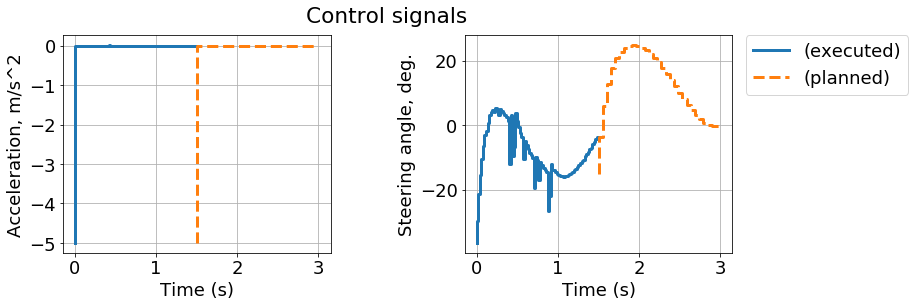

In [6]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)
# control limits

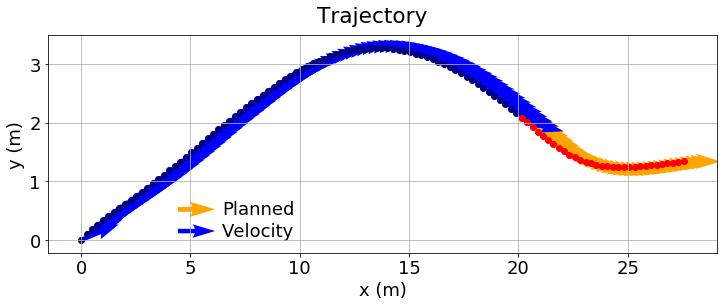

In [7]:
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
plt.show()

## x vs time and y vs time, separately, with the boundaries

Final state:
(x,y): 20.412432560621756 2.003129926567029


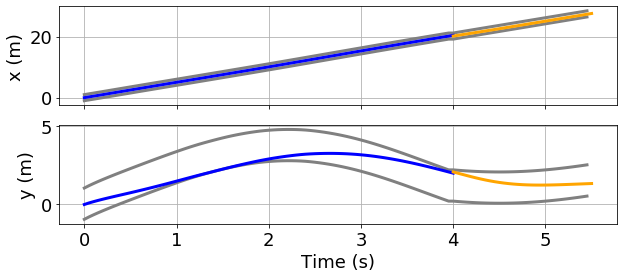

In [8]:
print("Final state:")
print("(x,y):", x_plan[0,-1], x_plan[1,-1])

fig1, ax1, ax2 = mpcprob.model.plot_with_time(x_plan, mpcprob.x_opt, boundary_up, boundary_low)

In [9]:
# This is the road to my parents' house, distances in meters.
'''
road_left = np.array([
[2.519, 117.514],
[10.68, 117.192],
[22.303, 116.549],
[30.712, 115.585],
[40.357, 112.691],
[50.744, 107.226],
[50.249, 98.224],
[48.765, 84.721],
[47.529, 74.754],
[47.158, 64.466],
[47.034, 53.535],
[47.529, 41.318],
[48.024, 31.994],
[48.518, 22.028],
[58.41, 22.671],
[68.303, 23.635],
[77.453, 23.153],
])

road_right = np.array([
[2.519, 109.155],
[10.68, 109.316],
[22.427, 108.19],
[30.094, 107.708],
[38.626, 105.297],
[42.83, 102.403],
[43.325, 98.545],
[42.583, 86.007],
[41.222, 75.719],
[40.852, 65.431],
[40.357, 53.856],
[40.852, 41.318],
[41.346, 30.869],
[45.179, 14.955],
[57.916, 14.312],
[68.056, 15.276],
[77.206, 14.312],
])

plt.scatter(road_left[:,0], road_left[:,1])
plt.scatter(road_right[:,0], road_right[:,1])
'''

'\nroad_left = np.array([\n[2.519, 117.514],\n[10.68, 117.192],\n[22.303, 116.549],\n[30.712, 115.585],\n[40.357, 112.691],\n[50.744, 107.226],\n[50.249, 98.224],\n[48.765, 84.721],\n[47.529, 74.754],\n[47.158, 64.466],\n[47.034, 53.535],\n[47.529, 41.318],\n[48.024, 31.994],\n[48.518, 22.028],\n[58.41, 22.671],\n[68.303, 23.635],\n[77.453, 23.153],\n])\n\nroad_right = np.array([\n[2.519, 109.155],\n[10.68, 109.316],\n[22.427, 108.19],\n[30.094, 107.708],\n[38.626, 105.297],\n[42.83, 102.403],\n[43.325, 98.545],\n[42.583, 86.007],\n[41.222, 75.719],\n[40.852, 65.431],\n[40.357, 53.856],\n[40.852, 41.318],\n[41.346, 30.869],\n[45.179, 14.955],\n[57.916, 14.312],\n[68.056, 15.276],\n[77.206, 14.312],\n])\n\nplt.scatter(road_left[:,0], road_left[:,1])\nplt.scatter(road_right[:,0], road_right[:,1])\n'

In [37]:
from roadrunner import Roadrunner
from scipy.optimize import curve_fit
from collections import deque

from road import road_center

N_POINTS,_ = np.shape(road_center)
road_width = np.ones(N_POINTS)*2.0

angles = np.empty(N_POINTS-1)
for i in range(N_POINTS-1):
    angles[i] = np.arctan2((road_center[i+1,1]-road_center[i,1]),(road_center[i+1,0]-road_center[i,0]))


<Curve (degree=29, dimension=2)>


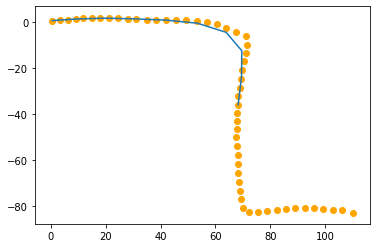

In [38]:
# What to do:
# 1. get better data set - done
# 2. parametrize x(s) and y(s) for road
# 3. better data set should fix data fitting
# 4. better data fitting: curves should match, e.g. curve k ends with derivative k' and curve k+1 should start with derivative k'
# in that way, they are always continuous
# we can set this up (discretely) with ipopt
import bezier

nodes = np.asfortranarray(np.transpose(road_center[0:0+P,:]))
curve = bezier.Curve.from_nodes(nodes)
print(curve)
ax = curve.plot(10)
ax.scatter(road_center[:,0], road_center[:,1], color='orange')

30 -94.66617630318545
31 -89.69702866662142
32 -94.66617630318522
33 -85.57446826831827
34 -85.39756324607306
35 -89.7072290197065
36 -89.70931629622368
37 -83.2502269442673
38 -83.2502269442673
39 -85.20468918829303
40 -81.12068155114581
41 -38.08351300955781
42 6.311130216170333
43 6.3285675262452505
44 3.086647393298211
45 6.311130216170084
46 8.544216066115638
47 3.086647393298211
48 0.33516237488270484
49 -8.222145583499971
50 -4.922860425243341
51 -5.659953823430295
52 -14.554109868993216


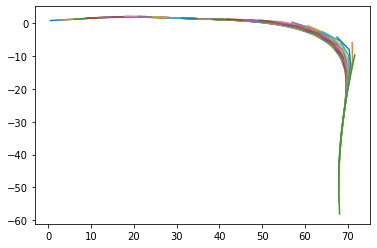

In [42]:
P = 30

for i in range(P,N_POINTS-1):
    road_b = Roadrunner.to_body_frame(road_center[i-P:i,:], angles[i])

    nodes = np.asfortranarray(np.transpose(road_b))
    curve = bezier.Curve.from_nodes(nodes)
    
    tmp = curve.evaluate_multi(np.linspace(0,9*0.05,10))
    x_b = tmp[0,:]
    y_b = tmp[1,:]
    
    x_b = np.reshape(x_b, (10,1))
    y_b = np.reshape(y_b, (10,1))
    fit_b = np.hstack([x_b, y_b])
    fit_world = Roadrunner.to_world_frame(fit_b, angles[i])
    print(i, angles[i]*180/np.pi)
    
    plt.plot(fit_world[:,0], fit_world[:,1], label=str(i))



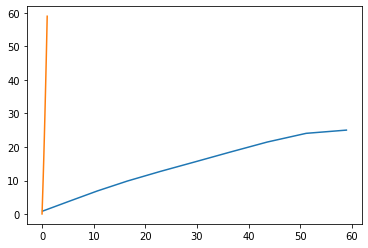

In [31]:
tmp = np.array(
[[ 0.09740539,  5.3043471,  10.70796172, 16.54794246, 22.8738061,  29.53950922,
  36.43721327, 43.62469314 ,51.1407678,  58.93449833,],
 [ 0.92563124,  3.89249926,  6.93187306,  9.89555303 ,12.73167464, 15.55453526,
  18.50602683, 21.49913987, 24.08157234, 25.04110635,]])